# Figure 4 (Part 1). Age-Related (Long-Term) Changes in Timescale
In this notebook, we look at the modulation of neuronal timescale across cortex as a function of age.

In the previous notebook, we showed that neuronal timescale hierarchy across the cortex, inferred from resting state intracranial data, is associated with structural hierarchies (in T1wT2w and gene expression gradients). Brain structure is not static, however, as it undergoes many changes during early development and throughout aging, especially in elderly populations. Many such changes co-vary with changes in cellular and synaptic parameters, such as loss of PV+ inhibitory neurons and GluN2B-containing NMDA receptors (e.g., [Pagasiou et al., 2019][pegasiou2019]). Cognitively, older adults show impairments in higher cognitive functions, such as working memory and attention. If neuronal dynamics are supported by structural properties of the brain and ultimately enable complex behaviors, we would also expect changes in neuronal timescale over longer timescales, through the course of years. In particular, we hypothesize that older adults would have __shorter neuronal timescales__, as they often exhibit a decreased ability to hold multiple objects in working memory, potentially caused by a shorter synaptic integration window or reduced recurrent activity, or both. We look at the effect of aging on timescale in the same MNI intracranial dataset, but across subjects.

---

### Per-Subject Average Timescale

The ideal analysis here is a mixed effects model to jointly estimate the effect of age and anatomical hierarchy (with T1T2 as an regressor, e.g.) on timescale, but the overall data coverage is very poor (~10% of total subj x parcel matrix is non-empty) and different across subjects. So we'd have to perform a lot of imputation to fill out that data matrix.

That being the case, we can only look at the average effect across both space (hierarchy) and age, which will confound and/or diminish our estimate of both effects, if there are any. Averaging across subjects for the per-parcel timescale estimate is not too bad, since each parcel has a relatively large sampling of age ranges (see coverage figure in the last notebook), and we expect a rather large spatial effect in the first place. 

But averaging across parcels for the per-subject estimate is more strongly biased by the non-uniform coverage of each patient, such that the per-patient timescale estimate essentially comes from a handful of adjacent parcels. This is especially true since most ECoG patients are implanted with limited coverage for seizure localization in a narrow region. Therefore, we need to normalize timescale for each patient by the parcel average (or max) first before averaging across parcels to remove the spatial effect. Kinda janky, but best I can think of given the sparse sampling problem.

We set a threshold on how many parcels the subject needs to have to be included in this analysis in the first place. Doesn't have to be a large value, since each person usually only has 5-20% coverage (10-30 out of 180).

[pegasiou2019]:http://dx.doi.org/10.1101/2020.01.21.913475

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import sys
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr, ttest_1samp, linregress
from seaborn import despine

sys.path.append('../')
import echo_utils

font = {'family' : 'Arial',
        'weight' : 'regular',
        'size'   : 14}
plt.rc('font', **font)
plt.rc('image', cmap='inferno')

C_ORD = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig_path = '../figures/mni/%s.pdf'
save_plot=True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load parcellation projected ECoG data

In [2]:
d_query = 4
df_W_max = pd.read_csv('../data/df_human_W_max_%i.csv'%d_query, index_col=0)
df_tau_weighted = pd.read_csv('../data/df_human_tau_weighted_%i.csv'%d_query, index_col=0)
#df_struct = pd.read_csv('../data/df_structural_avg.csv', index_col=0)

# take out genes because there's a lot of operating on them
#df_genes = df_struct[df_struct.columns[1:]]
df_ecog = pd.read_csv('../data/df_human.csv', index_col=0)
#mmp_aggr = pd.read_csv('../data/mmp_macro.csv', index_col=0, names=['parcel','macro_region', 'macro_labels'])

# get patient info for age-related analysis
df_patient = df_ecog.groupby('patient').mean()[['gender', 'age']].astype(int)
df_patient.index = df_patient.index.astype(int)

# patient parcel coverage
w_thres = 0.5

df_patient.insert(len(df_patient.columns), 'coverage', np.sum(df_W_max>=w_thres,1))
df_patient.insert(len(df_patient.columns), 'pct_coverage', np.sum(df_W_max>=w_thres,1)/len(df_W_max.columns))

# compute thresholded and weighted average
df_tau_threshed = df_tau_weighted[df_W_max>=w_thres]
#tau_parcel = echo_utils.compute_weighted_average(df_tau_weighted, df_W_max, w_thres, method='weighted')*1000 # convert to ms
#df_tau = pd.DataFrame(np.vstack((tau_parcel, np.log10(tau_parcel))).T, columns=['tau', 'logtau'], index=tau_parcel.index)
#df_tau.to_csv('../data/df_tau_avg.csv')

### Normalized timescale across age

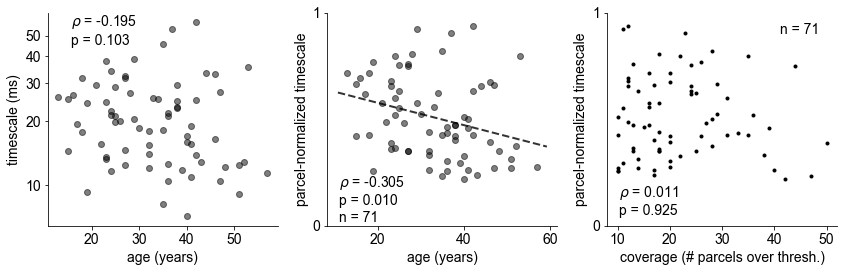

In [26]:
# threshold for including subjects if they have at least this many parcels
n_parcel_thresh = 10

# unnormalized averages over parcels per patient
tau_subj = echo_utils.compute_weighted_average(df_tau_weighted, df_W_max, w_thres, method='weighted', axis=1)
x = df_patient['age'][df_patient['coverage']>=n_parcel_thresh]
y = tau_subj[df_patient['coverage']>=n_parcel_thresh]*1000
rho, pv = spearmanr(x,y)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.semilogy(x, y, 'ok', alpha=0.5);
plt.xlabel('age (years)'); plt.ylabel('timescale (ms)'); 
plt.yticks(np.arange(10,60, 10), (np.arange(10, 60, 10)).astype(int));
plt.tick_params('y', which='minor', left=False, labelleft=False)
s = echo_utils.sig_str(rho, pv, form='text')
plt.annotate(s, xy=(0.1, 0.85), xycoords='axes fraction')

# normalized averages over parcels per patient
df_tau_threshed_parcelnorm = df_tau_threshed/df_tau_threshed.max()
tau_subj_normed = df_tau_threshed_parcelnorm.mean(axis=1)
y = tau_subj_normed[df_patient['coverage']>=n_parcel_thresh]
rho, pv = spearmanr(x,y)
s = echo_utils.sig_str(rho, pv, form='text') +'\nn = %i'%len(x)
m,b,_,_,_ = linregress(x, y.values)

plt.subplot(1,3,2)
plt.plot(x, y, 'ok', alpha=0.5);
XL= np.array(plt.xlim())
plt.plot(XL,XL*m+b, 'k--', lw=2, alpha=0.8) 
plt.xlabel('age (years)'); plt.ylabel('parcel-normalized timescale'); despine()
plt.ylim([0, 1])
plt.yticks([0,1]);
plt.annotate(s, xy=(0.05, 0.02), xycoords='axes fraction')

x = df_patient[df_patient['coverage']>=n_parcel_thresh]['coverage']
rho, pv = spearmanr(x,y)
s = echo_utils.sig_str(rho, pv, form='text')

plt.subplot(1,3,3)
plt.plot(x, y, '.k', alpha=1);
plt.xlabel('coverage (# parcels over thresh.)'); plt.ylabel('parcel-normalized timescale'); despine()
plt.ylim([0, 1])
plt.yticks([0,1]);
plt.annotate(s, xy=(0.05, 0.05), xycoords='axes fraction')
plt.annotate('n = %i'%len(x), xy=(0.75, 0.9), xycoords='axes fraction')


plt.tight_layout()
plt.savefig(fig_path%'tau_age',  bbox_inches='tight')

### Average cortical timescale decreases with age
The unnormalized per-patient average timescale decreases with age, but the effect is weak. As expected, the parcel-normalized average estimates a much larger effect in the negative correlation between timescale and age. This means that older adults on average have shorter intrinsic timescales as measured via ECoG. Previous reports have reported loss of NMDA receptors (subunit 2B, in particular) in older rats, potentially implicating that as a mechanism of shortened spontaneous dynamics. Lastly, we check that the decrease in timescale across age is not a function of coverage (last plot), though there seems to be a weird bump in the 30-40 parcel zone.

---

### Region Specific Changes in Timescale
The above result shows overall decrease in ECoG timescale when adjusted for region, but is there spatial specificity to the negative correlation between timescale and age? Once again, since coverage is non-uniform across subjects, and is generally sparse and different for each individual region, we can compute a timescale-age correlation for each parcel, but each parcel will have different subjects' data. The following analysis also only includes parcels where there are at least n subjects with data (above the confidence threshold of w=0.5).

colormap sequential: [-7.50e-01, 0.00e+00, 7.50e-01] (opaque)


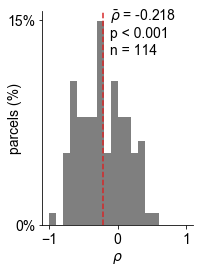

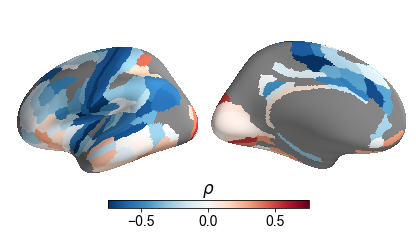

In [28]:
# minimum number of subjects that passed threshold in a parcel to include parcel
min_subjs = 6

# for each parcel, record the number of subjects included, and the spearman rho and p-value
df_age_corr=pd.DataFrame(index=df_tau_weighted.columns, columns=['n_subjs', 'rho', 'pv'])
for parcel, col in df_tau_threshed.iteritems():
    df_age_corr['n_subjs'].loc[parcel] = (~np.isnan(col)).sum()
    if df_age_corr['n_subjs'].loc[parcel]>=3:
        # hard threshold of having at least 3 subjects because correlation won't run otherwise
        rho, pv = spearmanr(df_patient['age'], col, nan_policy='omit')
    else:
        # otherwise just fill up with nans
        rho, pv = np.nan, np.nan
    df_age_corr['rho'].loc[parcel], df_age_corr['pv'].loc[parcel] = rho, pv
        
# only count correlations from parcels that had min # of subjs, set those that did not meet threshold to nan
parcel_corr = df_age_corr['rho'].astype(float)
parcel_corr[df_age_corr['n_subjs']<=min_subjs]=np.nan
x = parcel_corr.values

# t-test on whether parcels have positive or negative correlation in aggregate
tt_pv = ttest_1samp(x, 0, nan_policy='omit')[1]

# plot
plt.figure(figsize=(3,4))
plt.hist(x[~np.isnan(x)], bins=np.arange(-1,1.1,0.1), color='k', alpha=0.5)
plt.axvline(np.nanmean(x), color=C_ORD[3], ls='--')
plt.xlabel(r'$\rho$');plt.ylabel('parcels (%)', labelpad=-15);
s = echo_utils.sig_str(np.nanmean(x), tt_pv, form='text', corr_letter=r'$\bar{\rho}$')+'\nn = %i'%len(x[~np.isnan(x)])
plt.annotate(s, xy=(0.45, 0.8), xycoords='axes fraction')
plt.xticks([-1,0,1]); plt.yticks(np.array([0,15])/100*sum(~np.isnan(x)), ['0%', '15%'])
despine(); plt.tight_layout()
plt.savefig(fig_path%'tau_age_parcel', bbox_inches='tight')

# plot spatial distribution of correlation
plt.figure(figsize=(6,6))
echo_utils.plot_MMP(x, fig_path%'map_tau_age', minmax=[-.75,.75], cmap='RdBu_r', title=r'$\rho$', bp=0)

### Regional differences in age-timescale relationship
From the distribution, we see that across parcels, timescale is on average negatively correlated with age, which agrees with the subject-average analysis above. Looking across the cortex, sensorimotor, temporal, and frontal regions have the largest negative correlations, while visual regions consistently have positive correlations, i.e., timescale increases with age. This effect is robust under a range of threshold values for the minimum number of subjects a parcel must have in order to be included.

One potential explanation is the combination of the following: 1) visual regions have high numbers of PV+ interneurons, 2) older adults experience a selective loss of those interneurons, 3) PV expression is negatively correlated with timescale. Therefore, loss of PV+ interneurons would lead to longer timescales in visual cortex, though this is a just-so story. The key caveat/assumption here is that **expression in a region may not be correlated with its change in expression across aging.** A similar case can be made for (loss of) NMDA synpases and frontal region decrease in timescale.

---

# Ignore for now
---
### Age-Tau Correlation vs. Gene Expression 
One way to check the above logic is to see if the correlation coefficient within a parcel is then correlated with the expression value of certain genes. Note that this is not quite the ideal thing we want: we would like to see if the age-related expression change of a __single gene__ is correlated with its overall expression at a single region. Assuming gene expression changes contributes to timescale changes (mechanistically, though we've only shown correlations), then we can use timescale as an index for __combined gene expression__. As in, the combined change in expression of many genes gives rise to a __single tau estimate__ at a region.

Nevertheless, we can ask: which genes' expression correlate with, not timescale itself, but the change in timescale across aging.

In [5]:
# # gene expression vs. tau-age correlation within parcel
# plt.figure(figsize=(12,4))

# # age-timescale correlation vs. gene expression PCA
# x = gene_grad[:,2]
# y = parcel_corr.values
# rho, pv_est, pv, _ = echo_utils.perm_spearman(x,y,1000)
# s = echo_utils.sig_str(rho, pv, form='text')
# plt.subplot(1,3,1)
# plt.plot(x, y, 'ok', alpha=0.5)
# plt.xlabel('Gene Expression PC3'); plt.ylabel('Spearman Corr.'); despine()
# plt.annotate(s, xy=(0.7, 0.85), xycoords='axes fraction');

# # correlation between PCs and age-tau correlation map
# plt.subplot(1,3,2)
# all_pc_rhos = np.array([echo_utils.perm_spearman(x, y, 1000, 'shuffle')[0] for x in gene_grad.T])
# plt.bar(range(1,n_pcs+1), all_pc_rhos, fc='k', alpha=0.5)
# plt.xticks([1, 10], ['1', '10']);
# plt.xlabel('Principal Component'); plt.ylabel('Spearman Rho'); despine();
# plt.tight_layout()


# # age-time scale correlation vs. a single gene
# struct_feat = 'VIP'
# x = df_struct[struct_feat].values
# y = parcel_corr.values
# rho, pv_est, pv, _ = echo_utils.perm_spearman(x,y,1000)
# s = echo_utils.sig_str(rho, pv, form='text')

# plt.subplot(1,3,3)
# plt.plot(x, y, 'ok', alpha=0.5)
# plt.xlabel(struct_feat); plt.ylabel('Spearman Corr.'); despine()
# plt.annotate(s, xy=(0.7, 0.05), xycoords='axes fraction');

# plt.savefig(fig_path[:-4]%('mmp_parcel_agecorr_meta_%i'%(d_query)), bbox_inches='tight')

### Age-Tau Correlation Does Not Follow Dominant Gene Expression Gradient
Unlike the timescale map across the brain, the correlation map between age and timescale does not follow the dominant gradient of gene expression (PC1), but are moderately correlated with several of the subsequent PCs. As such, we then find instead the highest correlated genes to the age-tau map.

In [6]:
# # compute correlation of age-timescale-corr with individual genes
# df_age_corr_all = pd.DataFrame(index=df_struct.columns[1:], columns=['rho', 'pv'])
# for i_f, s_f in enumerate(df_struct.columns[1:]):
#     # no resampling
#     rho, pv = spearmanr(df_struct[s_f], parcel_corr.values, nan_policy='omit')    
#     # resample, takes really long
#     #rho, _, pv, _ = echo_utils.perm_spearman(df_struct[s_f], parcel_corr.values)
#     df_age_corr_all.loc[s_f] = rho, pv
    
# echo_utils.print_gene_list(df_age_corr_all.sort_values('rho')[-500:], 'go_agetau_pos.txt')
# echo_utils.print_gene_list(df_age_corr_all.sort_values('rho')[:500], 'go_agetau_neg.txt')

# print(df_age_corr_all.sort_values('rho')['rho'][:30])
# print(df_age_corr_all.sort_values('rho')['rho'][-30:])

Printing out the list of genes that are most correlated with the age-timescale association returns nothing obvious by eye, though it's interesting that GABBR2 (GABAB receptor subunit) has a very strong correlation. Submitting the 500 most and least correlated genes to GeneOntology results in no significant findings.

In [7]:
# plt.figure(figsize=(15,20))
# for i_r, r in enumerate(df_tau_macro.columns):
#     plt.subplot(6,4,i_r+1)
#     plt.semilogy(df_patient['age'], df_tau_macro[r], '.k')
#     rho,pv = spearmanr(df_patient['age'], df_tau_macro[r], nan_policy='omit')
#     plt.tick_params(axis='y', which='both', left='off', labelleft='off')
# #    plt.yscale('log')
# #    plt.yticks([]);

#     plt.xlim([10,60]); despine()
    
#     plt.title('%s: \n'%r + r'$\rho$=%.3f, p=%.3f'%(rho,pv))

# plt.tight_layout()

Again, timescale-age correlations are consistently negative, but differ in strength across areas. Sensorimotor and premotor have the strongest effects, while visual areas are again (slightly) positive.